In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [8]:
# Load model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # Adjust for your model
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/GenAI/IDVmodel.pth'))
model.eval()

# Choose the target layer (e.g., the last convolutional layer)
target_layer = model.layer4[2].conv3

In [9]:
from torchvision import transforms
from PIL import Image

def preprocess_image(img_path):
    # Same transformations as used for training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load image and apply transformations
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image


In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the specified device

def predict(image_path, model, class_names):
    image = preprocess_image(image_path)
    image = image.to(device)  # Move to the same device as your model

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class_index = predicted.item()
        predicted_class_name = class_names[predicted_class_index]

    return predicted_class_index, predicted_class_name

In [11]:
def show_cam_on_image(img_path, cam, predicted_class_name):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.float32(cv2.resize(img, (224, 224))) / 255

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_img = heatmap + np.float32(img)
    cam_img = cam_img / np.max(cam_img)

    # Display original and CAM overlay side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(cam_img)
    axs[1].set_title(f'Grad-CAM\nPrediction: {predicted_class_name}')
    axs[1].axis('off')

    plt.show()

In [7]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hooks for gradients and activations
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        # Register hooks to the target layer
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        model_output = self.model(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())

        # Zero grads
        self.model.zero_grad()
        class_loss = model_output[0, target_class]
        class_loss.backward()

        # Get hooked gradients and activations
        gradients = self.gradients.data.numpy()[0]
        activations = self.activations.data.numpy()[0]

        # Weighted sum of activations
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


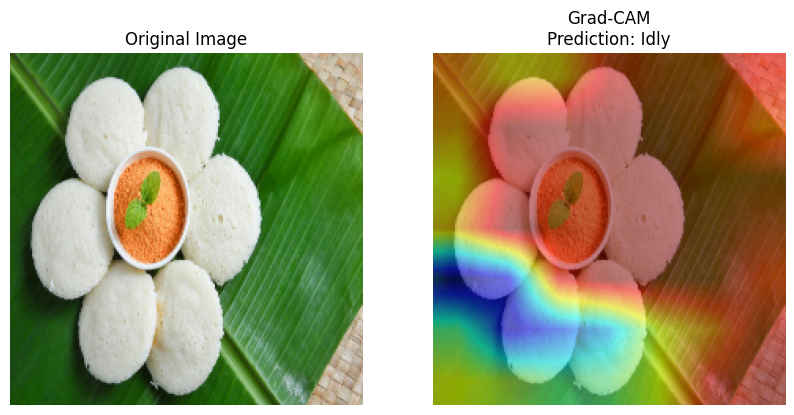

In [12]:
# Define class names
class_names = ['Idly', 'Dosai', 'Vadai']  # Replace with your actual class names

# Load and preprocess the image
image_path = '/content/drive/MyDrive/Colab Notebooks/GenAI/IDV Dataset/testData/images200.jpg'
preprocessed_image = preprocess_image(image_path)

# Predict the class
class_idx, predicted_class_name = predict(image_path, model, class_names)

# Generate CAM
grad_cam = GradCAM(model, target_layer)  # Make sure grad_cam is initialized correctly
cam = grad_cam.generate_cam(preprocessed_image)

# Visualize the result
show_cam_on_image(image_path, cam, predicted_class_name)

In [13]:
# Define class names
class_names = ['Idly', 'Dosai', 'Vadai']  # Replace with your actual class names

# List of image paths
image_paths = [
    '/content/drive/MyDrive/Colab Notebooks/GenAI/IDV Dataset/testData/images200.jpg',
    '/content/drive/MyDrive/Colab Notebooks/GenAI/IDV Dataset/testData/images266.jpg',
    '/content/drive/MyDrive/Colab Notebooks/GenAI/IDV Dataset/testData/images279.jpg',
    '/content/drive/MyDrive/Colab Notebooks/GenAI/IDV Dataset/testData/images300.jpg',
    '/content/drive/MyDrive/Colab Notebooks/GenAI/IDV Dataset/testData/images353.jpg',
    '/content/drive/MyDrive/Colab Notebooks/GenAI/IDV Dataset/testData/images643.jpg',
    # Add more image paths as needed
]

# Loop through each image
for image_path in image_paths:
    # Load and preprocess the image
    preprocessed_image = preprocess_image(image_path)

    # Predict the class
    class_idx, predicted_class_name = predict(image_path, model, class_names)

    # Generate CAM
    grad_cam = GradCAM(model, target_layer)  # Make sure grad_cam is initialized correctly
    cam = grad_cam.generate_cam(preprocessed_image)

    # Visualize the result
    show_cam_on_image(image_path, cam, predicted_class_name)

Output hidden; open in https://colab.research.google.com to view.